In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
%matplotlib inline
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

import astropy
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import LambdaCDM

from PIL import Image

# These cuts get you a 4x4 arcmin square centered on the image center of the fields
img_cuts = {'a2744':[[519,4520],[412,4413]],
            'm0416':[[367,4368],[380,4381]]}
img_files = {'a2744':'Files/abell2744_RGB.fits',
             'm0416':'Files/macs0416_RGB.fits'}

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}


In [24]:
cluster = 'm0416'
catalog = "Files/" + cluster + "_master_cleaned.csv"

#Set up clusters, not clusters, and unknowns
dzcut=0.02; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

clustnum = len(clusterarr)
nclustnum = len(ncluster)
print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))


0.3960252040816326 0.007215352640991353
0.02164605792297406
146
90
125


In [25]:
# Read in RGB file 
RGB = fits.open(img_files[cluster])

# Put separate extensions into own R/G/B arrays
imr=Image.fromarray(RGB[1].data,mode=None) 
img=Image.fromarray(RGB[2].data,mode=None)
imb=Image.fromarray(RGB[3].data,mode=None)

# Merge them back into one image
merged=Image.merge("RGB",(imr,img,imb))

# Conversion factor to translate between x & y and pixels
# In units of arcseconds per pixel
conv = 23.8809/398.015 

# Cut image down to square shape & zoom in since it's a little big
xx = img_cuts[cluster][0] # sets area to cut to
yy = img_cuts[cluster][1]
val = 0 # sets zoom in

imgcut = np.array(merged)[xx[0]+val:xx[1]-val,yy[0]+val:yy[1]-val]

In [57]:
#Set up images
cosmo = LambdaCDM(H0 = 70, Om0 = 0.3, Ode0 = 0.7)
img = fc.imgclass("Files/" + cluster + "_images.dat", zclus[cluster], cosmo)
print(len(img.xarr))

Read image data from file Files/m0416_images.dat
95


In [42]:
#Ways to assign probabilities
def normalize(X, p):
    copyX = np.copy(X)
    copyp = np.copy(p)
    for i in range((len(X[0]))):
        mn = np.min(X[:,i])
        mx = np.max(X[:,i])
        copyX[:,i] = (X[:,i] - mn) / (mx - mn)
        copyp[:,i] = (p[:,i] - mn) / (mx - mn)
    
    return copyX, copyp
    
def Knn(X, y, p, k):
    normX, normp = normalize(X, p)
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def Rnn(X, y, p, r):
    normX, normp = normalize(X, p)
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(normX, y)
    return model.predict_proba(normp)[:,1], model.predict(normp)

def box(X, y, p, numx, numy):
    minm = np.min(Xcm[:,0])
    maxm = np.max(Xcm[:,0])
    minc = np.min(Xcm[:,1])
    maxc = np.max(Xcm[:,1])
    w = maxm - minm
    h = maxc - minc
    minm -= 0.01 * w
    maxm += 0.01 * w
    minc -= 0.01 * h
    maxc += 0.01 * h
    
    boxw = (maxm - minm) / numx
    boxh = (maxc - minc) / numy
    grid = np.zeros((numx, numy, 2))
    
    for i, point in enumerate(X):
        xcoor = int((point[0] - minm) / boxw)
        ycoor = int((point[1] - minc) / boxh)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += y[i]
        
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    for i, point in enumerate(p):
        if point[0] >= minm and point[0] < maxm and point[1] >= minc and point[1] <= maxc:
            xcoor = int((point[0] - minm) / boxw)
            ycoor = int((point[1] - minc) / boxh)
            if not grid[xcoor, ycoor, 1] == 0:
                probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
                if probs[i] > 0.5: classes[i] = 1
                    
    return probs, classes

def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    res = clustercolor - predict(clustermag)
    sigma = np.std(res)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes

In [58]:
clusterData = [[row['master_x'], row['master_y'], row['master_mag814'], 1] for row in clusterarr]
unknownData = [[row['master_x'], row['master_y'], row['master_mag814'], 0] for row in unknown]
data = np.array(clusterData + unknownData)

print(len(data))
    
#draw scatter plot of uncertainties in varying cluster members, or in scattering
def scatterDraw(n, scatter, ax, probs = [], color = "red"):
    global data
    colors = ["red", "blue", "green"]
    data[clustnum:,3] = probs
    
    gal = fc.galclass(data)
    gal.scale()
    alldeflect = []
    
    for i in range(n):
        gal.draw(scatter)
        deflect, gamma = gal.calcdefbasic(images)
        alldeflect.append(deflect)

    alldeflect = np.array(alldeflect)
    for i in range(len(images)):
        x = alldeflect[:,i,0]
        y = alldeflect[:,i,1]
        ax.scatter(x, y, color = color, alpha = 0.5)
    
    return np.mean(alldeflect, axis = 0)


271


In [60]:
#Get probability arrays
knnprob = Knn(Xcm, y, unknownXcm, 16)[0]
rnnprob = Rnn(Xcm, y, unknownXcm, 0.15)[0]
boxprob = box(Xcm, y, unknownXcm, 2, 14)[0]
sigmaclass = sigmaCut(Xcm, y, unknownXcm, 1.0)[1]


Read in 271 galaxies
Read in 271 galaxies
Read in 271 galaxies
Read in 271 galaxies
Read in 271 galaxies
Read in 271 galaxies


Text(0.5, 1.0, 'Boxes')

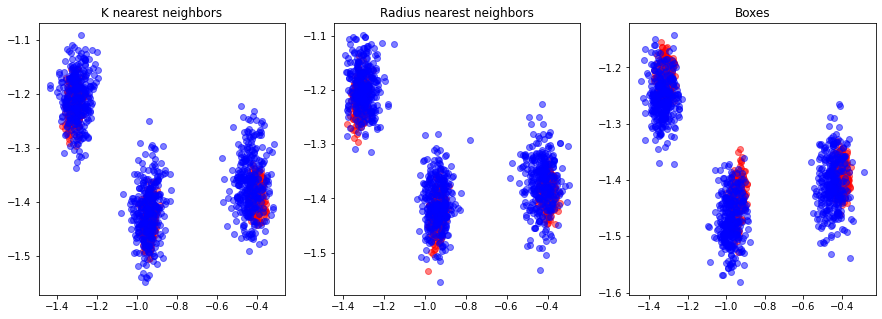

In [12]:
images = np.array([[-28.5912, -24.0012], [-23.6743, -34.4608], [6.5976, -45.8501]])
fig,((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,5))

scatterDraw(300, True, ax1, sigmaclass)
scatterDraw(300, True, ax2, sigmaclass)
scatterDraw(300, True, ax3, sigmaclass)

scatterDraw(300, True, ax1, knnprob, "blue")
scatterDraw(300, True, ax2, rnnprob, "blue")
scatterDraw(300, True, ax3, boxprob, "blue")
ax1.set_title("K nearest neighbors")
ax2.set_title("Radius nearest neighbors")
ax3.set_title("Boxes")

In [61]:
def getStats(n, probs, scatter, img = img):
    global data
    data[clustnum:,3] = probs

    gal = fc.galclass(data)
    gal.scale()

    deflects = fc.defclass()
    deflects.draw(gal, img, 1.0, [1.0], n, scatter = scatter, useD = True)
    return deflects.marr, deflects.Garr, deflects.Cmat

def scatterMeans(n, probs, scatter, ax, color):
    marr = getStats(n, probs, scatter)[0]
    ax.scatter(marr[0,:,0], marr[0,:,1], color = color)
    return marr



    
    

Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
0.0234600746669848
-0.0027643164766714265


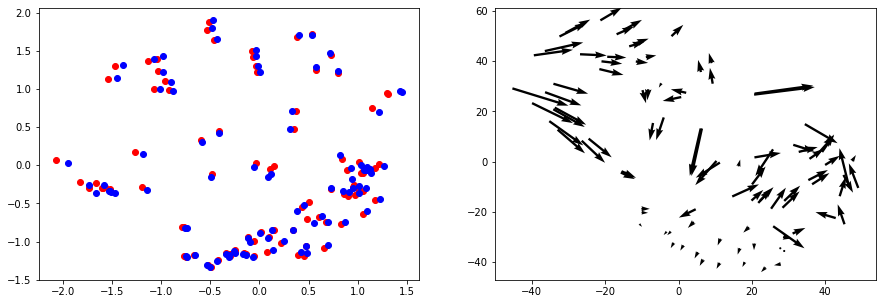

In [70]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))
marr1 = scatterMeans(200, sigmaclass, True, ax1, "red")
marr2 = scatterMeans(200, knnprob, True, ax1, "blue")
diff = marr2 - marr1

ax2.quiver(img.xarr[:,0], img.xarr[:,1], diff[0,:,0], diff[0,:,1])

count = 0
for i in diff[0,:,0]:
    if i > 0:
        count += 1
        
print(np.mean(diff[0,:,0]))
print(np.mean(diff[0,:,1]))


Read in 271 galaxies
Read in 271 galaxies
Read in 271 galaxies
Read in 271 galaxies
Mass scatter: 
X mean: 0.00012999200729359568
X std: 0.02528086546041375
Y mean: 0.00025326092902789346
Y std: 0.02624936458411168


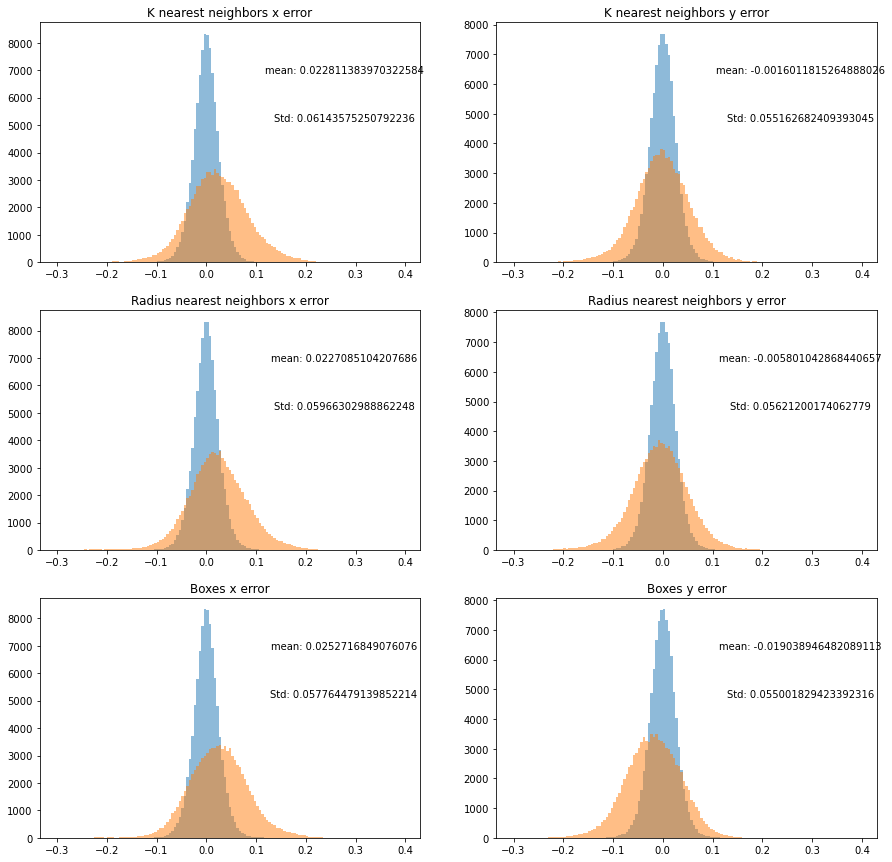

In [47]:
#get overall histograms
def plothist(probs, ax, ax2):
    global data
    pdelta = []
    data[clustnum:,3] = probs
    gal = fc.galclass(data)
    gal.scale()
    
    for i in range(reps):
        gal.draw(True)
        deftmp = gal.calcdef(img)[0]
        deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))

        pdelta.append(deftmp - defbase)
        
    pdelta = np.array(pdelta)
    pdeltax = np.reshape(pdelta[:,:,0], (-1))
    pdeltay = np.reshape(pdelta[:,:,1], (-1))

    ax.hist(mdeltax, bins = bins, alpha = 0.5)
    ax.hist(pdeltax, bins = bins, alpha = 0.5)
    ax2.hist(mdeltay, bins = bins, alpha = 0.5)
    ax2.hist(pdeltay, bins = bins, alpha = 0.5)
    
    ax.text(0.8, 0.8, "mean: " + str(np.mean(pdeltax)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    ax.text(0.8, 0.6, "Std: " + str(np.std(pdeltax)), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
    
    ax2.text(0.8, 0.8, "mean: " + str(np.mean(pdeltay)), horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes)
    ax2.text(0.8, 0.6, "Std: " + str(np.std(pdeltay)), horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes)



reps = 1000

data[clustnum:,3] = sigmaclass
gal = fc.galclass(data)
gal.scale()
gal.draw(False)

defbase = gal.calcdef(img)[0]
defbase = defbase*np.reshape(img.Darr,(img.nimg,1))

mdelta = []

for i in range(reps):
    gal.draw(True)
    deftmp = gal.calcdef(img)[0]
    deftmp = deftmp*np.reshape(img.Darr,(img.nimg,1))
    
    mdelta.append(deftmp - defbase)
mdelta = np.array(mdelta)

mdeltax = np.reshape(mdelta[:,:,0], (-1))
mdeltay = np.reshape(mdelta[:,:,1], (-1))
bins = np.arange(-0.3, 0.4, 0.005)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))


plothist(knnprob, ax1, ax2)
plothist(rnnprob, ax3, ax4)
plothist(boxprob, ax5, ax6)

ax1.set_title("K nearest neighbors x error")
ax2.set_title("K nearest neighbors y error")
ax3.set_title("Radius nearest neighbors x error")
ax4.set_title("Radius nearest neighbors y error")
ax5.set_title("Boxes x error")
ax6.set_title("Boxes y error")

print("Mass scatter: ")
print("X mean: " + str(np.mean(mdeltax)))
print("X std: " + str(np.std(mdeltax)))
print("Y mean: " + str(np.mean(mdeltay)))
print("Y std: " + str(np.std(mdeltay)))

In [33]:
# #Visualize vector field of biases
# xnum = 20
# ynum = 20
# minx = -60
# maxx = 60
# miny = -50
# maxy = 60

# f = open("Files/mock_images_macs.txt", "a")
# f.write("#Mock images\n")
# f.write("1\n2\n3\n4\n5\n1\n" + str((xnum + 1) * (ynum + 1)) + "\n")

# for i in range(ynum + 1):
#     for j in range(xnum + 1):
#         x = minx + j * (maxx - minx) / xnum
#         y = miny + i * (maxy - miny) / ynum
#         f.write(str(x) + " " + str(y) + " 1.0 1.0\n")
        
# f.close()

Read image data from file Files/mock_images_macs.txt
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0


Text(0.5, 1.0, 'Box differences')

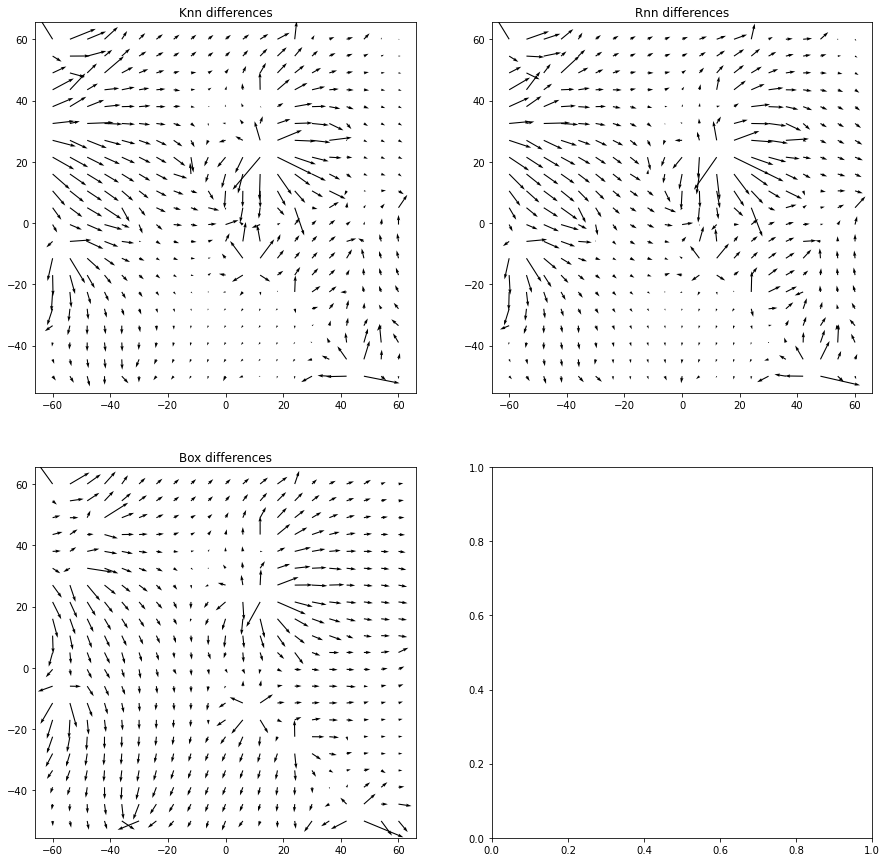

In [48]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
imgmock = fc.imgclass("Files/mock_images_macs.txt", 0.0, cosmo)

marr = getStats(100, sigmaclass, True, imgmock)[0]
marrk = getStats(100, knnprob, True, imgmock)[0]
marrr = getStats(100, rnnprob, True, imgmock)[0]
marrbox = getStats(100, boxprob, True, imgmock)[0]

diffk = marrk - marr
diffr = marrr - marr
diffbox = marrbox - marr

ax1.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffk[0,:,0], diffk[0,:,1])
ax2.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffr[0,:,0], diffr[0,:,1])
ax3.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffbox[0,:,0], diffbox[0,:,1])

ax1.set_title("Knn differences")
ax2.set_title("Rnn differences")
ax3.set_title("Box differences")

Read image data from file Files/mock_images_full.txt
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0


Text(0.5, 1.0, 'Box differences')

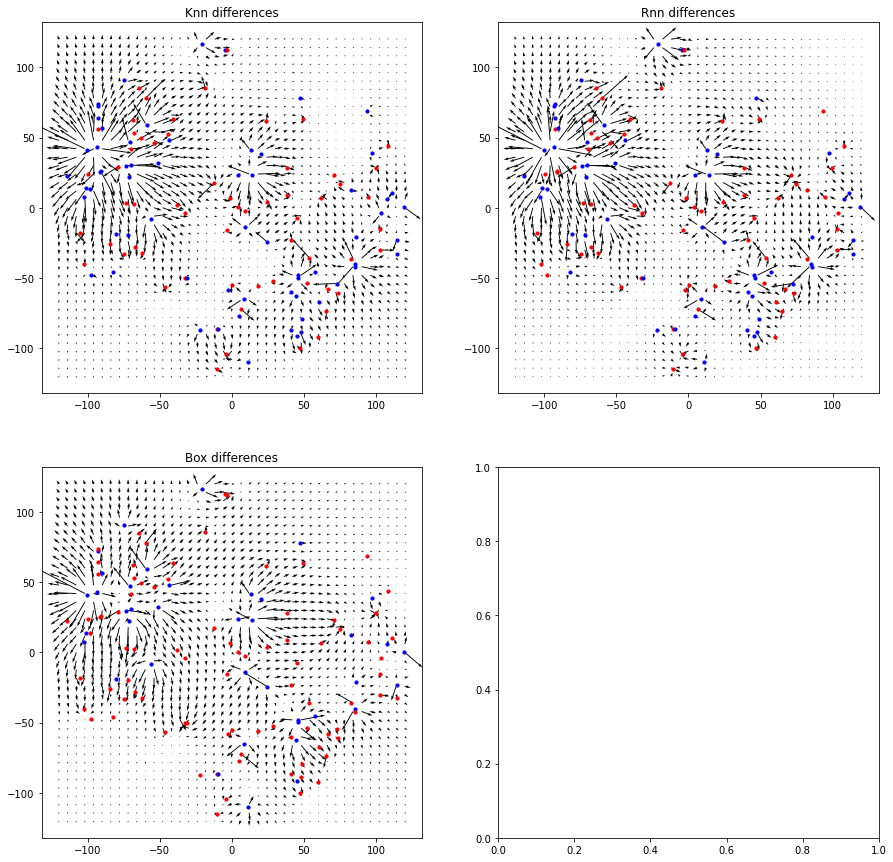

In [49]:
#Create vector field
def plotdiffs(ax, orig, probs):
    for i in range(len(orig)):
        if unknown[i].master_x > -120 and unknown[i].master_x < 120 and unknown[i].master_y > -120 and unknown[i].master_y < 120:
            diff = abs(orig[i] - probs[i])
            if orig[i] < probs[i]:
                ax.scatter(unknown[i].master_x, unknown[i].master_y, color="blue", s = 10)
            else:
                ax.scatter(unknown[i].master_x, unknown[i].master_y, color="red", s = 10)
            
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
imgmock = fc.imgclass("Files/mock_images_full.txt", 0.0, cosmo)

marr = getStats(100, sigmaclass, True, imgmock)[0]
marrk = getStats(100, knnprob, True, imgmock)[0]
marrr = getStats(100, rnnprob, True, imgmock)[0]
marrbox = getStats(100, boxprob, True, imgmock)[0]

diffk = marrk - marr
diffr = marrr - marr
diffbox = marrbox - marr

ax1.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffk[0,:,0], diffk[0,:,1])
ax2.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffr[0,:,0], diffr[0,:,1])
ax3.quiver(imgmock.xarr[:,0], imgmock.xarr[:,1], diffbox[0,:,0], diffbox[0,:,1])

plotdiffs(ax1, sigmaclass, knnprob)
plotdiffs(ax2, sigmaclass, rnnprob)
plotdiffs(ax3, sigmaclass, boxprob)

ax1.set_title("Knn differences")
ax2.set_title("Rnn differences")
ax3.set_title("Box differences")


In [50]:
print(np.sum(sigmaclass))

61.0


Read image data from file Files/mock_images_full.txt


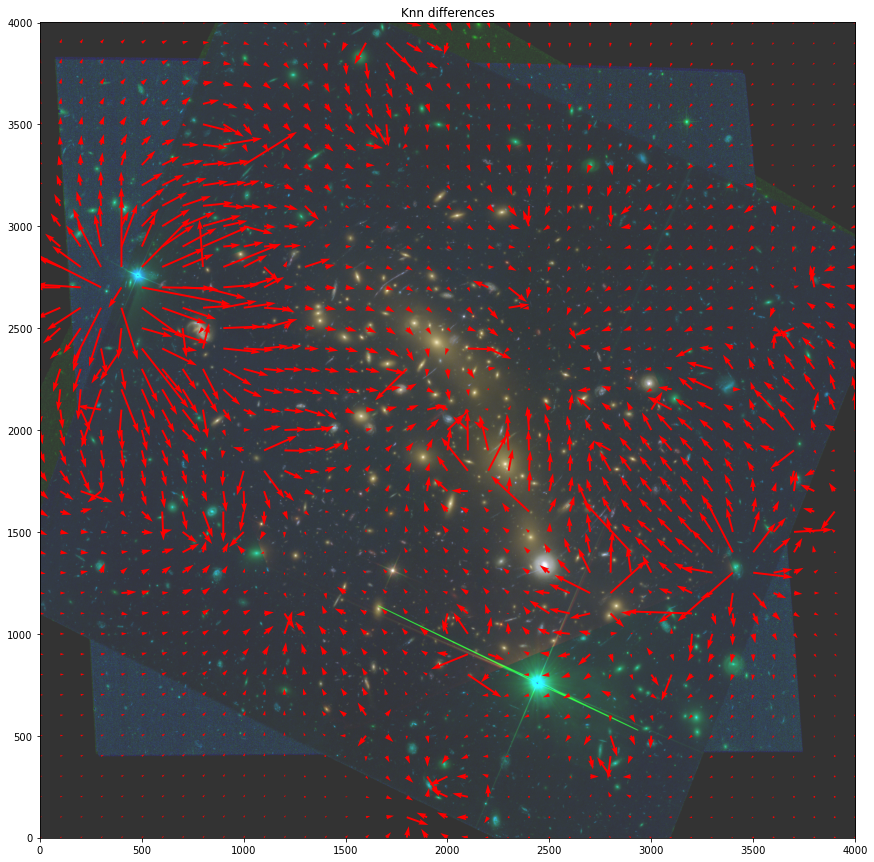

In [36]:
# Plot RGB image
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(imgcut, origin='lower', alpha = 0.8)

imgmock2 = fc.imgclass("Files/mock_images_full.txt", 0.0, cosmo)

ax.quiver(imgmock2.xarr[:,0]/conv + (len(imgcut)/2), imgmock2.xarr[:,1]/conv + (len(imgcut)/2), diffk[0,:,0], diffk[0,:,1], color = "red")

ax.set_title("Knn differences")
#Plot galaxies


plt.show()

In [37]:
print(len(img.xarr))

95


In [65]:
#Comparing 2D gaussians via ellipses

def drawEllipses(probs):
    rightcount = 0
    rownum = 10
    colnum = 10
    fig, axs = plt.subplots(rownum, colnum, figsize = (15, 15))
    marr, garr, Cmar = getStats(100, sigmaclass, True)
    marr2, garr2, Cmar2 = getStats(100, probs, True)

    for i, ax in enumerate(fig.axes):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if i >= len(img.xarr):
            continue
        cov = Cmar[0,2 * i : 2*i + 2, 2 * i : 2*i + 2]
        evalue, evector = np.linalg.eig(cov)
        
        if evector[0, 0] < 0:
            evector[:,0] *= -1
            
        angle = np.arcsin(evector[1, 0]) * 180 / np.pi
        ellipse1 = Ellipse(xy = (0, 0), width = 2 * math.sqrt(evalue[0]), height = 2 * math.sqrt(evalue[1]), angle = angle, alpha = 0.7, color = "red")
        
        cov = Cmar2[0,2 * i : 2*i + 2, 2 * i : 2*i + 2]
        evalue, evector = np.linalg.eig(cov)
        
        if evector[0, 0] < 0:
            evector[:,0] *= -1
            
        angle = np.arcsin(evector[1, 0]) * 180 / np.pi
        pos = marr2[0, i] - marr[0, i]
        ellipse2 = Ellipse(xy = pos, width = 2 * math.sqrt(evalue[0]), height = 2 * math.sqrt(evalue[1]), angle = angle, alpha = 0.7, color = "blue")
    
        ax.add_artist(ellipse1)
        ax.add_artist(ellipse2)
        
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.2)
        
        if pos[0] > 0:
            rightcount += 1
        
    plt.show()
    print(rightcount)
        
        


Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0


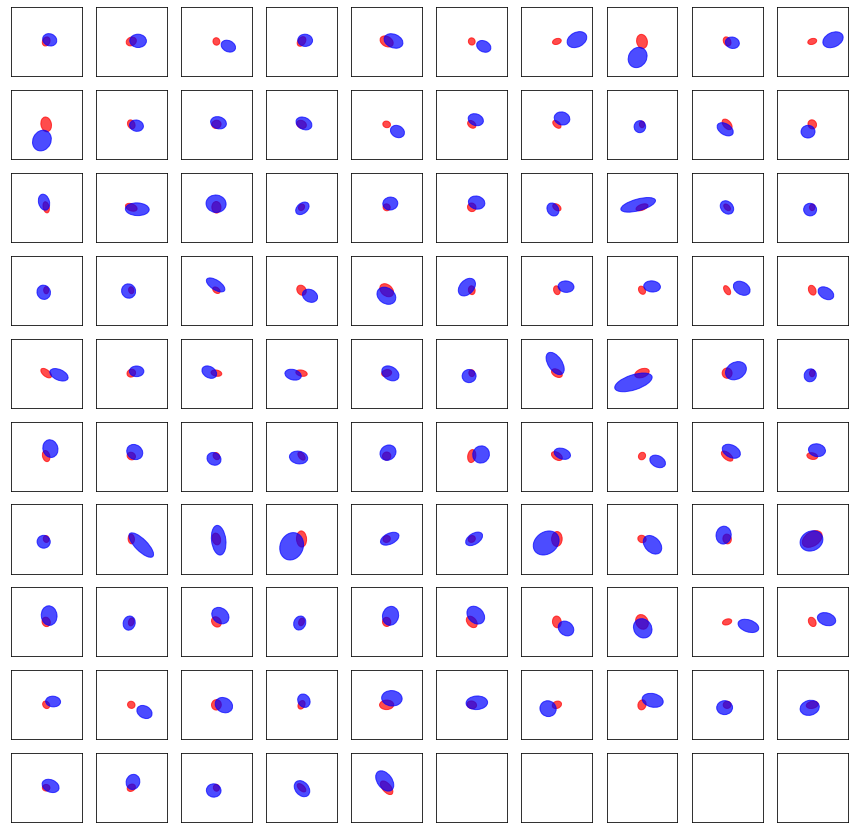

59


In [66]:
drawEllipses(knnprob)

Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


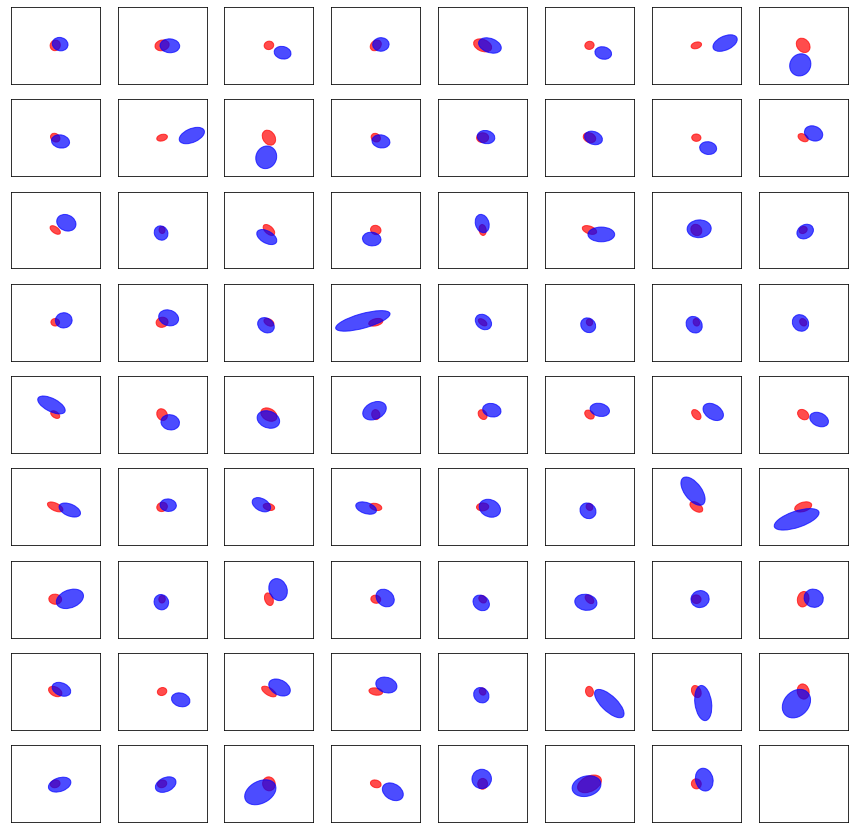

In [51]:
drawEllipses(rnnprob)

Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500
Read in 271 galaxies
Generating deflection distribution: a = 1.0
Step 0
Step 500
Step 1000
Step 1500
Step 2000
Step 2500


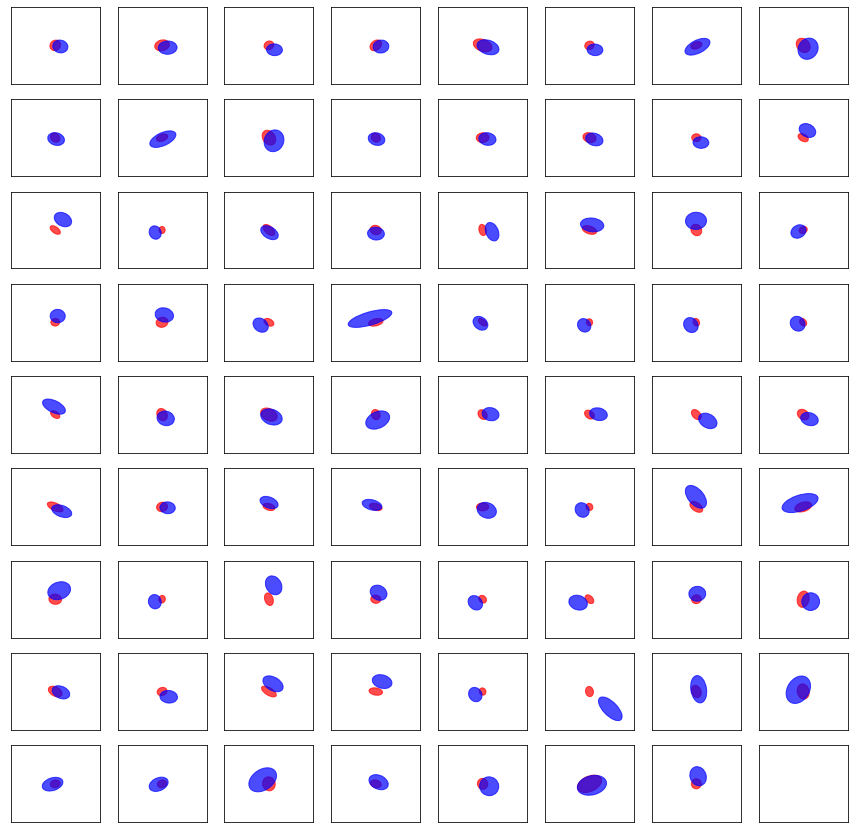

In [41]:
drawEllipses(boxprob)